# Аналіз глибинних поглядів
### Магістерська робота
<i>Савенко Ілля</i>


В даній роботі розглядається задача інтелектуального аналізу даних тексту а саме пошук глибинних поглядів. Робота розглядає задачу аналіз тексту з соціальної мережі Телеграм. В ході проведення дослідження було взято дані з телеграм каналу публічної людини Ігоря Лаченкова. Публічний блог має охоплення у 1 136 690 людей(станом на 21 квітня). Канал обʼєднує певну соціальну думку категорії українців. Мета дослідження - це проаналізувати текстові властивості та побудувати задачу класифікації(регресії), що дозволять побудувати модель відображення соціальної думки щодо подій, описаних на каналі. Дана робота не досліджує саму соціальну думку щодо описаних подій, а досліджує побудову звʼязку між соціальною думкою аудиторії та подією. В подальшому для відтворення та передбачення думки щодо новостворених новин.

#### Імпортування необхідних інструментальних бібілотек

In [4]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import re
import random
import json

#### Імпорт бібліотек для позначення частин мови
Pos-tagging

In [5]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer(lang='uk')

#### Імпорт бібліотек для обробки інтелектуального аналізу тексту

In [6]:
import nltk
from nltk.probability import FreqDist
from sklearn.model_selection import train_test_split
from scipy import sparse as sp_sparse
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from gensim.models import Word2Vec

import tensorflow as tf
from keras import backend as K

In [7]:
from IPython.core.display import display, HTML

#### Імпорт бібліотек для побудови моделі класифікатору та навчання

In [8]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

#### Імпорт бібліотек для зняття метрик з побудованої моделі

In [9]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import det_curve

## Опис даних
Як було вже вищеописано, дані узяті з каналу публічної людини. Структура повідомлень - це пост з мережі Телеграм. В ньому пристуні такі влсативості:
- id: ідентифікатор повідомлення
- peer_id: ідентифікатор каналу
- date: дата публікації
- message: текст повідомлення
- out: чи вихідне повідомлення
- mentioned: чи вказаний автор, який робив експорт
- media_unread: чи прочитані медіаматеріали користувачем
- silent: чи було надіслано повідомлення без нотифікованого сповіщення
- post: чи є це постом каналу
- from_scheduled: чи було надіслано запланованим
- legacy: чи застаріле по актуальності повідослення(чи було змінене воно згодом)
- pinned: закурпленість на каналі
- fwd_from_channel: чи було переслано з іношого каналу
- fwd_from_message: чи було переслано з іншого персонального повідомлення
- reply_to: чи має структуру відповіді - якщо так позначає ідентифікатор повідослення на яке була відповідь
- views: кількість переглядів
- forward: кількість пересилань
- reactions: реакції на повідомлення

Для дослідження було взято останні 13 000 повідомлень оскільки переважна більшість з них написана Українською мовою. Попередні пости були написані російською мовою. 

In [10]:
df = pd.read_csv("Лачен пише.csv", sep="|")[:13000]
df = df.sample(frac=1)
df

,id,peer_id,date,message,out,mentioned,media_unread,silent,post,from_scheduled,legacy,pinned,fwd_from_channel,fwd_from_message,reply_to,views,forwards,reactions
4315,23983,1536630827,"12/13/2022, 18:45:14","Якщо хтось до нас посунеться, я йому не заздрю...",False,False,False,False,True,False,False,False,None,None,None,487150.0,738.0,"{'❤': 24615, '🔥': 2870, '😁': 251, '😢': 38, '🤬'..."
9450,18283,1536630827,"08/31/2022, 13:42:05",Глава Європейської дипломатії Жозеп Боррель пі...,False,False,False,False,True,False,False,False,None,None,None,403747.0,540.0,"{'❤': 21939, '🔥': 1046, '😁': 128, '😢': 12, '🤬'..."
15,28666,1536630827,"04/24/2023, 22:07:54",ЄС введе 11-й за пакет антиросійських санкцій ...,False,False,False,False,True,False,False,False,None,None,None,488893.0,144.0,"{'❤': 873, '🔥': 63, '😁': 106, '😢': 583, '🤬': 1..."
4705,23550,1536630827,"12/04/2022, 14:36:06",росіяни від ранку вже 5 разiв обстріляли Нікоп...,False,False,False,False,True,False,False,False,None,None,None,509270.0,211.0,"{'❤': 69, '🔥': 36, '😁': 33, '😢': 1452, '🤬': 19..."
9680,18033,1536630827,"08/25/2022, 22:20:45",Українці поки що не потребують далекобійних ра...,False,False,False,True,True,False,False,False,None,None,None,455118.0,694.0,"{'❤': 343, '🔥': 0, '😁': 131, '😢': 953, '🤬': 22..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2592,25868,1536630827,"01/22/2023, 18:58:39",росіяни намагаються наступати на чотирьох напр...,False,False,False,False,True,False,False,False,None,None,None,547562.0,622.0,"{'❤': 19493, '🔥': 2854, '😁': 278, '😢': 141, '🤬..."
873,27744,1536630827,"03/15/2023, 10:23:00","Естонія, Литва і Польща просувають на $10 нижч...",False,False,False,False,True,False,False,False,None,None,None,603573.0,264.0,"{'❤': 25546, '🔥': 2147, '😁': 136, '😢': 0, '🤬':..."
4023,24288,1536630827,"12/20/2022, 17:04:15",США в новому пакеті допомоги Україні передадут...,False,False,False,False,True,False,False,False,None,None,24039,488077.0,456.0,"{'❤': 17438, '🔥': 1419, '😁': 119, '😢': 8, '🤬':..."
10199,17434,1536630827,"08/16/2022, 06:16:02","Міноборони росії повідомляє, що вранці в район...",False,False,False,False,True,False,False,False,None,None,17428,441439.0,1201.0,"{'❤': 1391, '🔥': 0, '😁': 27098, '😢': 79, '🤬': 49}"


In [11]:
def extract_proper_name(text):
    return re.findall(r"\b[А-ЯЄІЇ]{1,}[а-яєії]{0,}\b", text)

In [12]:
pd.isna(df.loc[[6]]["message"]).bool()

False

In [13]:
proper_names = []
for index, row in df.iterrows():
    if pd.isna(row["message"]):
        continue
    proper_names_local = extract_proper_name(row["message"])
    proper_names = proper_names + proper_names_local

In [14]:
morph.parse("гей")

[Parse(word='гей', tag=OpencorporaTag('INTJ'), normal_form='гей', score=1.0, methods_stack=((DictionaryAnalyzer(), 'гей', 1, 0),)),
 Parse(word='гей', tag=OpencorporaTag('NOUN,anim masc,nomn'), normal_form='гей', score=1.0, methods_stack=((DictionaryAnalyzer(), 'гей', 128, 0),))]

## Попередня обробка текстових повідомлень

In [15]:
processing_df = df["message"]
processing_df

4315     Якщо хтось до нас посунеться, я йому не заздрю...
9450     Глава Європейської дипломатії Жозеп Боррель пі...
15       ЄС введе 11-й за пакет антиросійських санкцій ...
4705     росіяни від ранку вже 5 разiв обстріляли Нікоп...
9680     Українці поки що не потребують далекобійних ра...
                               ...                        
2592     росіяни намагаються наступати на чотирьох напр...
873      Естонія, Литва і Польща просувають на $10 нижч...
4023     США в новому пакеті допомоги Україні передадут...
10199    Міноборони росії повідомляє, що вранці в район...
8435                                                  😂😂😂😂
Name: message, Length: 13000, dtype: object

In [16]:
print(morph.parse("Азовсталь"))

[Parse(word='азовсталь', tag=OpencorporaTag('NOUN,femn,inan nomn'), normal_form='азовсталь', score=1.0, methods_stack=((DictionaryAnalyzer(), 'азовсталь', 182, 0),)), Parse(word='азовсталь', tag=OpencorporaTag('NOUN,femn,inan accs'), normal_form='азовсталь', score=1.0, methods_stack=((DictionaryAnalyzer(), 'азовсталь', 182, 3),))]


#### Стоп слова
Визначимо категорії стоп-слів. Вони є допоміжними та частіше всього не несуть велику кількість інформації
Віднесемо до цієї категорії усі службові частини мови: <i>прийменник, сполучник, частка, вигук</i>

In [17]:
stop_words_categories = ["PREP", "CONJ", "INTJ", "PRCL", "NPRO"]
def delete_stop_words(text):
    new_text = ""
    words = text.split(" ")
    for word in words:
        word_metainfo = random.choice(morph.parse(word))
        if word_metainfo.tag.POS not in stop_words_categories:
            new_text = new_text + " " + word
            
    return new_text.strip()

In [18]:
tt_stop_words = "Я на що та гору круту кремʼяную, буду камінь важкий підіймать"
delete_stop_words(tt_stop_words)

'Я гору круту кремʼяную, буду камінь важкий підіймать'

#### Приведення слів тексту до нормальної форми - стемінг
Зведення слів до нормальної форми - називний відмінок, однина

In [19]:
def norm_form(text):
    new_text = ""
    words = text.split(" ")
    for word in words:
        word_metainfo = random.choice(morph.parse(word))
        new_text = new_text + " " + word_metainfo.normal_form
            
    return new_text.strip()

In [20]:
tt_norm_form = "Несучи вагу ту страшную, буду пісню веселу співать"
norm_form(tt_norm_form)

'несучи вага той страшную, бути пісня веселий співати'

#### Видалення розділових знаків та іншої нетекстової інформації

In [21]:
def extract_text_only(text):
    words = re.findall(r"[А-ЯЄІЇа-яєії]{1,}", text)
    return " ".join([word for word in words])

In [22]:
tt_text_only = "Я у темную нічку не видну, не стулю ні на хвильку очей!"
extract_text_only(tt_text_only)

'Я у темную нічку не видну не стулю ні на хвильку очей'

In [23]:
def text_processing(text):
    text = extract_text_only(text)
    text = delete_stop_words(text)
    text = norm_form(text)
    return text

In [24]:
tt_all_preprocessing = "Гетьте думи ви хмари осінні"
text_processing(tt_all_preprocessing)

'дума хмара осінній'

## Проведемо першопочаткове перетворення тексту
Видалимо усі розділові знаки та службові частини мови, проведемо стемінг

In [25]:
df["processed_text"] = df["message"]
df["processed_text"] = df["processed_text"].apply(str).apply(text_processing)

In [26]:
df["processed_text"]

4315     до посунутися заздрити секретар рнбо данілов п...
9450     глава європейський дипломатія жозепа боррель п...
15       єс ввести за пакет антиросійський санкція рані...
4705     росіянин ранка вже обстріляти нікопольщина гол...
9680     українка потребувати далекобійний ракета пента...
                               ...                        
2592     росіянин намагатися наступати чотири напрямок ...
873      естонія литва польща просувати нижчий гранични...
4023     сша новий пакет допомога україна передати засі...
10199    міноборони росія повідомляти вранці район трав...
8435                                                      
Name: processed_text, Length: 13000, dtype: object

In [27]:
df["reactions"][0]

"{'❤': 15, '🔥': 5, '😁': 31, '😢': 569, '🤬': 6503}"

### Парсинг позначок тексту
Як ми можемо звернути увагу на реакції, залишені читачами спільноти, допустимо зробити певний висновок відношення людини до тієї чи іншої новини. Опишемо припущення щодо емоціного відношення по емоджі:
- ❤: "любов" - може відображати певне тепле ставлення людини до новини, під якою вона поставила дану реакцію.
- 🔥: "вогник" - позитивне емоційне збудження до новини
- 😁: "сміх" - допис здався кумедним
- 😢: "плач" - допис має негативне забарвлення та відображає емоційне подавлення
- 🤬: "злість" - допис викликає відчуття злості та негативне збудження

Видалимо дані, де усі реакції дорівнюють 0, оскільки проведення аналізу тексту виконати неможливо. 

In [28]:
df["reactions"].value_counts()

{'❤': 0, '🔥': 0, '😁': 0, '😢': 0, '🤬': 0}                       1142
{'❤': 24615, '🔥': 2870, '😁': 251, '😢': 38, '🤬': 42}               1
{'❤': 16969, '🔥': 86, '😁': 1636, '😢': 94, '🤬': 470}               1
{'❤': 18950, '🔥': 933, '😁': 57, '😢': 222, '🤬': 51}                1
{'❤': 19654, '🔥': 2313, '😁': 253, '😢': 36, '🤬': 40}               1
                                                               ... 
{'❤': 8501, '🔥': 0, '😁': 588, '😢': 117, '🤬': 69}                  1
{'❤': 34754, '🔥': 2207, '😁': 550, '😢': 0, '🤬': 16}                1
{'❤': 17014, '🔥': 0, '😁': 104, '😢': 15, '🤬': 21}                  1
{'❤': 14554, '🔥': 0, '😁': 551, '😢': 19, '🤬': 36}                  1
{'❤': 949, '🔥': 538, '😁': 30286, '😢': 80, '🤬': 56, '🍾': 18}       1
Name: reactions, Length: 11859, dtype: int64

Бачимо, що маємо 1142 дописа, що не мають реакцій. Такі дописи вилучимо з нашого датасету.

In [29]:
empty_reactions = df["reactions"].value_counts().keys()[0]
df = df[df["reactions"] != empty_reactions]
df.head()

,id,peer_id,date,message,out,mentioned,media_unread,silent,post,from_scheduled,legacy,pinned,fwd_from_channel,fwd_from_message,reply_to,views,forwards,reactions,processed_text
4315,23983,1536630827,"12/13/2022, 18:45:14","Якщо хтось до нас посунеться, я йому не заздрю...",False,False,False,False,True,False,False,False,None,None,None,487150.0,738.0,"{'❤': 24615, '🔥': 2870, '😁': 251, '😢': 38, '🤬'...",до посунутися заздрити секретар рнбо данілов п...
9450,18283,1536630827,"08/31/2022, 13:42:05",Глава Європейської дипломатії Жозеп Боррель пі...,False,False,False,False,True,False,False,False,None,None,None,403747.0,540.0,"{'❤': 21939, '🔥': 1046, '😁': 128, '😢': 12, '🤬'...",глава європейський дипломатія жозепа боррель п...
15,28666,1536630827,"04/24/2023, 22:07:54",ЄС введе 11-й за пакет антиросійських санкцій ...,False,False,False,False,True,False,False,False,None,None,None,488893.0,144.0,"{'❤': 873, '🔥': 63, '😁': 106, '😢': 583, '🤬': 1...",єс ввести за пакет антиросійський санкція рані...
4705,23550,1536630827,"12/04/2022, 14:36:06",росіяни від ранку вже 5 разiв обстріляли Нікоп...,False,False,False,False,True,False,False,False,None,None,None,509270.0,211.0,"{'❤': 69, '🔥': 36, '😁': 33, '😢': 1452, '🤬': 19...",росіянин ранка вже обстріляти нікопольщина гол...
9680,18033,1536630827,"08/25/2022, 22:20:45",Українці поки що не потребують далекобійних ра...,False,False,False,True,True,False,False,False,None,None,None,455118.0,694.0,"{'❤': 343, '🔥': 0, '😁': 131, '😢': 953, '🤬': 22...",українка потребувати далекобійний ракета пента...


* Зведему кожний елемент в колонці реакцій в формат словника.
* Перетворимо дані позначки у нумеровані категорії для усіх текстових даних.

In [30]:
def convert_to_dict(text):
    json_acceptable_string = text.replace("'", "\"")
    json_dict = json.loads(json_acceptable_string)
    return dict(json_dict)

In [31]:
df["reactions"] = df["reactions"].apply(convert_to_dict)
df.head(3)

/tmp/ipykernel_7410/2484381893.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["reactions"] = df["reactions"].apply(convert_to_dict)


,id,peer_id,date,message,out,mentioned,media_unread,silent,post,from_scheduled,legacy,pinned,fwd_from_channel,fwd_from_message,reply_to,views,forwards,reactions,processed_text
4315,23983,1536630827,"12/13/2022, 18:45:14","Якщо хтось до нас посунеться, я йому не заздрю...",False,False,False,False,True,False,False,False,None,None,None,487150.0,738.0,"{'❤': 24615, '🔥': 2870, '😁': 251, '😢': 38, '🤬'...",до посунутися заздрити секретар рнбо данілов п...
9450,18283,1536630827,"08/31/2022, 13:42:05",Глава Європейської дипломатії Жозеп Боррель пі...,False,False,False,False,True,False,False,False,None,None,None,403747.0,540.0,"{'❤': 21939, '🔥': 1046, '😁': 128, '😢': 12, '🤬'...",глава європейський дипломатія жозепа боррель п...
15,28666,1536630827,"04/24/2023, 22:07:54",ЄС введе 11-й за пакет антиросійських санкцій ...,False,False,False,False,True,False,False,False,None,None,None,488893.0,144.0,"{'❤': 873, '🔥': 63, '😁': 106, '😢': 583, '🤬': 1...",єс ввести за пакет антиросійський санкція рані...


#### Знаходження емоджі з максимальною кількістю поставлених реакцій

In [32]:
def max_grab(emoji_dict):
    return max(emoji_dict, key=emoji_dict.get)

Оберемо випадкову реакцію та знайдемо реакцію з максимальним відгуком

In [33]:
random_attitude = random.choice(df["reactions"])
random_attitude

{'❤': 8432, '🔥': 575, '😁': 336, '😢': 37, '🤬': 140, '🍾': 10, '🎉': 1}

In [34]:
max_grab(random_attitude)

'❤'

In [35]:
df["max_reaction"] = df["reactions"].apply(max_grab)
df.head(4)

/tmp/ipykernel_7410/3717174282.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["max_reaction"] = df["reactions"].apply(max_grab)


,id,peer_id,date,message,out,mentioned,media_unread,silent,post,from_scheduled,legacy,pinned,fwd_from_channel,fwd_from_message,reply_to,views,forwards,reactions,processed_text,max_reaction
4315,23983,1536630827,"12/13/2022, 18:45:14","Якщо хтось до нас посунеться, я йому не заздрю...",False,False,False,False,True,False,False,False,None,None,None,487150.0,738.0,"{'❤': 24615, '🔥': 2870, '😁': 251, '😢': 38, '🤬'...",до посунутися заздрити секретар рнбо данілов п...,❤
9450,18283,1536630827,"08/31/2022, 13:42:05",Глава Європейської дипломатії Жозеп Боррель пі...,False,False,False,False,True,False,False,False,None,None,None,403747.0,540.0,"{'❤': 21939, '🔥': 1046, '😁': 128, '😢': 12, '🤬'...",глава європейський дипломатія жозепа боррель п...,❤
15,28666,1536630827,"04/24/2023, 22:07:54",ЄС введе 11-й за пакет антиросійських санкцій ...,False,False,False,False,True,False,False,False,None,None,None,488893.0,144.0,"{'❤': 873, '🔥': 63, '😁': 106, '😢': 583, '🤬': 1...",єс ввести за пакет антиросійський санкція рані...,🤬
4705,23550,1536630827,"12/04/2022, 14:36:06",росіяни від ранку вже 5 разiв обстріляли Нікоп...,False,False,False,False,True,False,False,False,None,None,None,509270.0,211.0,"{'❤': 69, '🔥': 36, '😁': 33, '😢': 1452, '🤬': 19...",росіянин ранка вже обстріляти нікопольщина гол...,🤬


In [36]:
df["max_reaction"].value_counts()

❤    7014
🤬    2635
🔥    1017
😁     720
😢     456
🤡      14
🍾       2
Name: max_reaction, dtype: int64

Можемо побачити, що в даних присутні аномалії. В даному випадку це реакція "клоун" та "привітання". Оскільки таких даних маємо у кількості 16, їх врахування в моделі буде обмежено. 

In [37]:
value_count_dict = dict(df["max_reaction"].value_counts())
value_count_dict

{'❤': 7014, '🤬': 2635, '🔥': 1017, '😁': 720, '😢': 456, '🤡': 14, '🍾': 2}

In [38]:
filtered_reactions_by_count = {}
MIN_COUNT = 400
for key, value in value_count_dict.items():
    if int(value) > MIN_COUNT:
        filtered_reactions_by_count[key] = value

Маємо усі реакції

In [39]:
allowed_reactions = list(filtered_reactions_by_count.keys())
allowed_reactions

['❤', '🤬', '🔥', '😁', '😢']

Фільтруємо дані

In [40]:
df = df[df["max_reaction"].isin(allowed_reactions)]

#### Категорізація

In [41]:
reaction_sample = df["reactions"][0]
reactions = list(reaction_sample.keys())
def categorize_emoji(reaction):
    emoji_index = reactions.index(reaction)
    return emoji_index

In [42]:
print(reactions)
print(categorize_emoji("🔥"))

['❤', '🔥', '😁', '😢', '🤬']
1


#### Сумісна категоризація
Обʼєднаємо категорії ❤ та 🔥 через їхню схожість та в подальшому окремо проаналізуємо результат


<i style="color: red;">Попередження: тільки для задачі аналітики кокретного каналу</i>

In [43]:
reactions_merged_common = [[reactions[0], reactions[1]], [reactions[2]], [reactions[3]], [reactions[4]]]
reactions_merged_common

[['❤', '🔥'], ['😁'], ['😢'], ['🤬']]

In [44]:
def categorize_group_emoji(emoji):
    for i, emoji_group in enumerate(reactions_merged_common):
        if emoji in emoji_group:
            return i

In [45]:
categorize_group_emoji('🔥')

0

In [46]:
df["max_reactions_category"] = df["max_reaction"].apply(categorize_emoji)
df["max_reactions_category_generalized"] = df["max_reaction"].apply(categorize_group_emoji)
df.head(4)

,id,peer_id,date,message,out,mentioned,media_unread,silent,post,from_scheduled,...,fwd_from_channel,fwd_from_message,reply_to,views,forwards,reactions,processed_text,max_reaction,max_reactions_category,max_reactions_category_generalized
4315,23983,1536630827,"12/13/2022, 18:45:14","Якщо хтось до нас посунеться, я йому не заздрю...",False,False,False,False,True,False,...,None,None,None,487150.0,738.0,"{'❤': 24615, '🔥': 2870, '😁': 251, '😢': 38, '🤬'...",до посунутися заздрити секретар рнбо данілов п...,❤,0,0
9450,18283,1536630827,"08/31/2022, 13:42:05",Глава Європейської дипломатії Жозеп Боррель пі...,False,False,False,False,True,False,...,None,None,None,403747.0,540.0,"{'❤': 21939, '🔥': 1046, '😁': 128, '😢': 12, '🤬'...",глава європейський дипломатія жозепа боррель п...,❤,0,0
15,28666,1536630827,"04/24/2023, 22:07:54",ЄС введе 11-й за пакет антиросійських санкцій ...,False,False,False,False,True,False,...,None,None,None,488893.0,144.0,"{'❤': 873, '🔥': 63, '😁': 106, '😢': 583, '🤬': 1...",єс ввести за пакет антиросійський санкція рані...,🤬,4,3
4705,23550,1536630827,"12/04/2022, 14:36:06",росіяни від ранку вже 5 разiв обстріляли Нікоп...,False,False,False,False,True,False,...,None,None,None,509270.0,211.0,"{'❤': 69, '🔥': 36, '😁': 33, '😢': 1452, '🤬': 19...",росіянин ранка вже обстріляти нікопольщина гол...,🤬,4,3


## Первинний аналіз тексту

In [47]:
df["words"] = df["processed_text"]
df["words"] = df["words"].apply(lambda text: text.split(" "))
df["words_len"] = df["words"].apply(lambda words: len(words))

In [48]:
df["words_len"].mean()

13.953132916737038

Середня довжина повідомлення - 14 слів у реченні.

### Duplicating categories

In [49]:
def show_category_sizes():
    print("0 category size: ", df[df["max_reactions_category_generalized"] == 0].shape)
    print("1 category size: ", df[df["max_reactions_category_generalized"] == 1].shape)
    print("2 category size: ", df[df["max_reactions_category_generalized"] == 2].shape)
    print("3 category size: ", df[df["max_reactions_category_generalized"] == 3].shape)

In [50]:
show_category_sizes()

0 category size:  (8031, 24)
1 category size:  (720, 24)
2 category size:  (456, 24)
3 category size:  (2635, 24)


In [ ]:
df.append(df[df["max_reactions_category_generalized"] == 1] * 4, ignore_index=True)
df.append(df[df["max_reactions_category_generalized"] == 2] * 5, ignore_index=True)
df.append(df[df["max_reactions_category_generalized"] == 3] * 2, ignore_index=True)

In [ ]:
show_category_sizes()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


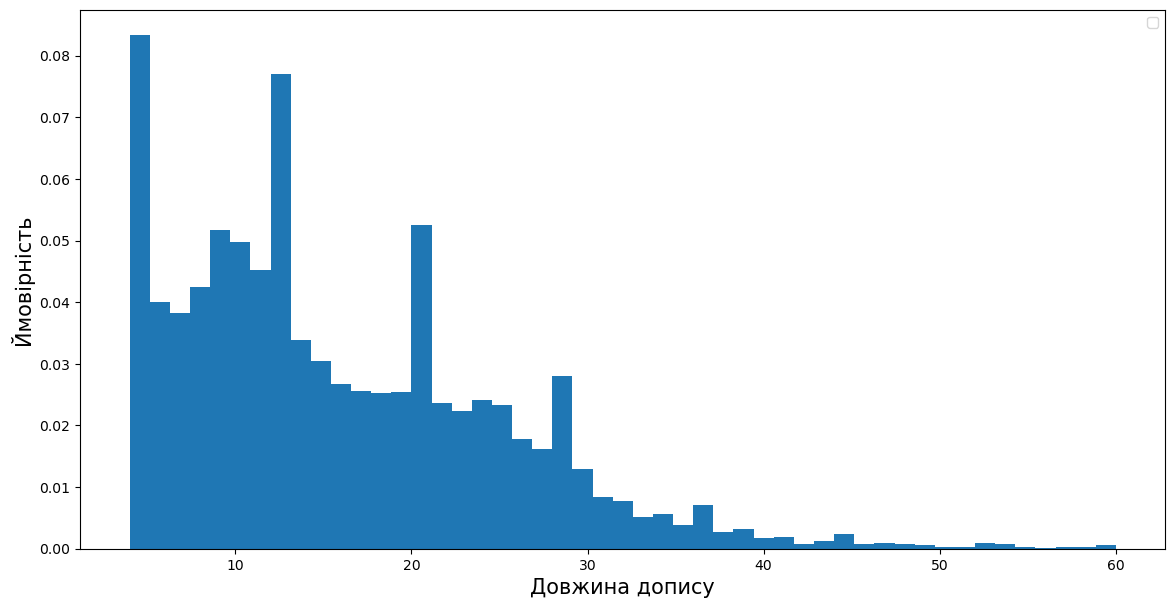

In [52]:
values = df["words_len"].values
bins = np.linspace(4, 60, 50)

fig = plt.figure(figsize = (14,7))
plt.hist(values, bins, density=True)
plt.xlabel("Довжина допису", fontsize=15)
plt.ylabel("Ймовірність", fontsize=15)
plt.legend(loc='upper right')
plt.show()

In [53]:
df["words"] = df["processed_text"].apply(lambda text: text.split(" "))

In [54]:
sns.set()
plt.rcParams['figure.figsize'] = [15, 20]

In [55]:
def draw_word_cloud():
    wordcloud = WordCloud(background_color="white", contour_width=0.1, scale=1,
                      contour_color="black",  max_font_size=150, random_state=42,
                      colormap="Dark2")
    for i, label_name in zip(range(10), np.unique(df['max_reactions_category'])):
        df_part = df[df['max_reactions_category'] == label_name]
        words = df_part['words']
        allwords = []
        for wordlist in words:
            allwords += wordlist

        mostcommon = FreqDist(allwords).most_common(100)

        wordcloud.generate(text=str(mostcommon))   
        plt.subplot(5, 2, i+1)
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title(label_name, fontsize=15)
    plt.show()

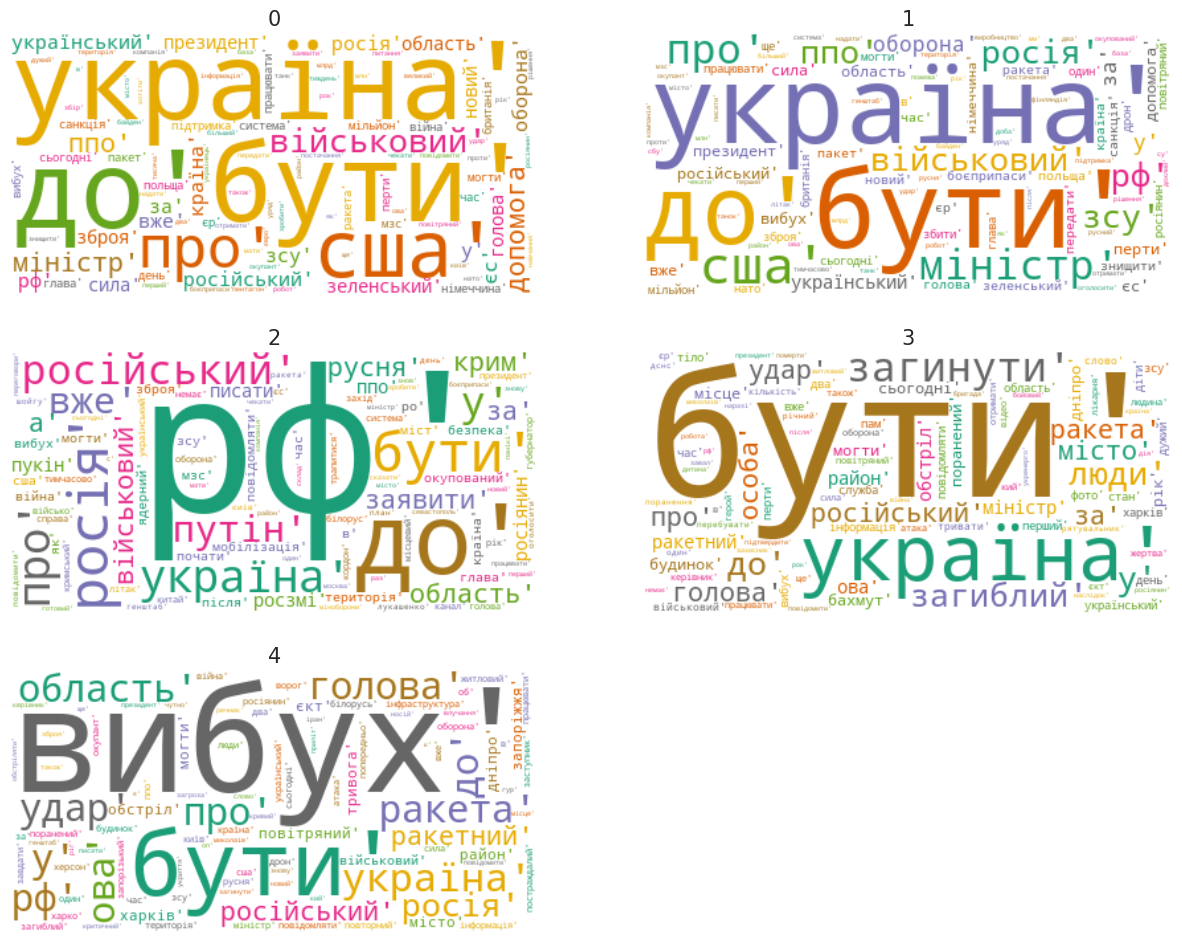

In [56]:
draw_word_cloud()

<table class="tg">
<thead>
  <tr>
    <th class="tg-0lax">ID</th>
    <th class="tg-0lax"><span style="font-weight:400;font-style:normal">Reaction</span></th>
  </tr>
</thead>
<tbody>
  <tr>
    <th class="tg-0lax">0</th>
    <th class="tg-0lax"><span style="font-weight:400;font-style:normal">❤</span></th>
  </tr>
  <tr>
    <td class="tg-0lax">1</td>
    <td class="tg-0lax"><span style="font-weight:400;font-style:normal">🔥</span></td>
  </tr>
  <tr>
    <td class="tg-0lax">2</td>
    <td class="tg-0lax"><span style="font-weight:400;font-style:normal">😁</span></td>
  </tr>
  <tr>
    <td class="tg-0lax">3</td>
    <td class="tg-0lax"><span style="font-weight:400;font-style:normal">😢</span></td>
  </tr>
  <tr>
    <td class="tg-0lax">4</td>
    <td class="tg-0lax"><span style="font-weight:400;font-style:normal">🤬</span></td>
  </tr>
</tbody>
</table>

In [57]:
words_to_drop = ["до", "бути", "україна", "що", "про", "у", "в", "п", "сша", "військовий"]
# words_to_drop = []
def drop_words_by_hands(words):
    for word_to_drop in words_to_drop:
        if word_to_drop in words:
            words.remove(word_to_drop)
    return words

In [58]:
df["words"] = df["words"].apply(drop_words_by_hands)

In [59]:
df["words"]

4315     [посунутися, заздрити, секретар, рнбо, данілов...
9450     [глава, європейський, дипломатія, жозепа, борр...
15       [єс, ввести, за, пакет, антиросійський, санкці...
4705     [росіянин, ранка, вже, обстріляти, нікопольщин...
9680     [українка, потребувати, далекобійний, ракета, ...
                               ...                        
2592     [росіянин, намагатися, наступати, чотири, напр...
873      [естонія, литва, польща, просувати, нижчий, гр...
4023     [новий, пакет, допомога, передати, засіб, висо...
10199    [міноборони, росія, повідомляти, вранці, район...
8435                                                    []
Name: words, Length: 11842, dtype: object

## Проектування ознак
На початку аналізу тексту, налаштуємо механізм вилучення ознак за методом n-gram

In [60]:
test_tokenization_message = "Гетьте думи ви хмари осінні"
words = nltk.word_tokenize(test_tokenization_message)

In [61]:
bigrams = nltk.ngrams(df["words"][2], n=2)

In [62]:
bigram_fdist = nltk.FreqDist(bigrams)

In [63]:
bigram_fdist.most_common(5)

[(('український', 'відбити'), 1),
 (('відбити', 'атака'), 1),
 (('атака', 'за'), 1),
 (('за', 'доба'), 1),
 (('доба', 'бахмутське'), 1)]

## Розділ вибірки на тренувальну, валідаційну та тестову
Розділ відбувається за такими правилами: 
* 20% - тестова вибірка
* 20% - валідаційна вибірка
* 60% - тренувальна вибірка

In [64]:
df_train, df_test = train_test_split(df, test_size=0.2, train_size=0.8)
df_train, df_val = train_test_split(df_train, test_size=0.25, train_size=0.75)

for tensorflow

In [65]:
df_train, df_test = train_test_split(df, test_size=0.2, train_size=0.8)

In [66]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9473 entries, 11781 to 2623
Data columns (total 24 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   id                                  9473 non-null   int64  
 1   peer_id                             9473 non-null   int64  
 2   date                                9473 non-null   object 
 3   message                             9454 non-null   object 
 4   out                                 9473 non-null   bool   
 5   mentioned                           9473 non-null   bool   
 6   media_unread                        9473 non-null   bool   
 7   silent                              9473 non-null   bool   
 8   post                                9473 non-null   bool   
 9   from_scheduled                      9473 non-null   object 
 10  legacy                              9473 non-null   bool   
 11  pinned                              947

In [67]:
df_train.head(2)

,id,peer_id,date,message,out,mentioned,media_unread,silent,post,from_scheduled,...,reply_to,views,forwards,reactions,processed_text,max_reaction,max_reactions_category,max_reactions_category_generalized,words,words_len
11781,15711,1536630827,"07/13/2022, 08:55:39",Міністр Оборони Рєзніков повідомив про поповне...,False,False,False,False,True,False,...,None,345728.0,639.0,"{'❤': 16148, '🔥': 0, '😁': 216, '😢': 0, '🤬': 21}",міністр оборона рєзніков повідомити про поповн...,❤,0,0,"[міністр, оборона, рєзніков, повідомити, попов...",9
8663,19187,1536630827,"09/16/2022, 08:03:52","Прошу ретвіт, треба щоб всі побачили про Ізюм",False,False,False,False,True,False,...,None,446260.0,143.0,"{'❤': 10673, '🔥': 130, '😁': 30, '😢': 879, '🤬':...",просити ретвіт треба побачити ізюм,❤,0,0,"[просити, ретвіт, треба, побачити, ізюм]",5


In [68]:
NUMBER_OF_CATEGORIES = 4

In [69]:
def from_category(categories):
    y_all = []
    for category in categories:
        y_cell = np.zeros((NUMBER_OF_CATEGORIES, ), dtype=int)
        y_cell[category] = 1
        y_all.append(y_cell)
    y_all = np.array(y_all)
    return y_all

In [70]:
# y_train = from_category(df_train["max_reactions_category"])
# y_test = from_category(df_test["max_reactions_category"])

In [71]:
y_train = from_category(df_train["max_reactions_category_generalized"])
y_test = from_category(df_test["max_reactions_category_generalized"])

# Перетворення тексту в нумерований формат
Для подальшого формування вхідного вектору моделі, дані будуть перетворені у нумерований формат.

## Bag-of-Words
Побудуємо словникову ознаку на основі N слів, що найчастіше зустрічаються.

In [72]:
word_counts = {}
def build_word_counts(words):
    for word in words:
        if word not in list(word_counts.keys()):
            word_counts[word] = 1
        word_counts[word] += 1

In [73]:
_ = df_train["words"].aggregate(build_word_counts)

Проведемо ранжування слів за частотою їх появ

In [74]:
words_by_freq = sorted(word_counts, key=word_counts.get, reverse=True)

words_to_index = {key: rank for rank, key in enumerate(words_by_freq, 0)}
index_to_words = {index: word for word, index in words_to_index.items()}

In [75]:
print("Розмір словника: ", len(words_by_freq), "\n", end="")
print("Топ-10", words_by_freq[:10])

Розмір словника:  13111 
Топ-10 ['вибух', 'рф', 'російський', 'росія', 'україна', 'міністр', 'за', 'ппо', 'ракета', 'український']


### Побудова BOW
Для кожного допису створимо нульовий вектор з розмірністю N і заповнимо його відповідними словами, що зустрілися в цьому дописі

In [76]:
dict_size = len(words_by_freq)
def message_bow_vec(words, words_to_index):
    result_vec = np.zeros(dict_size)
    for word in words:
        if word in words_to_index:
            result_vec[words_to_index[word]] += 1
    return result_vec

In [77]:
X_train_bow = sp_sparse.vstack([sp_sparse.csr_matrix(message_bow_vec(words, words_to_index)) for words in df_train["words"]])
X_val_bow = sp_sparse.vstack([sp_sparse.csr_matrix(message_bow_vec(words, words_to_index)) for words in df_val["words"]])
print("Train X shape -> ", X_train_bow.shape, "\nValidation X shape -> ", X_val_bow.shape)

Train X shape ->  (9473, 13111) 
Validation X shape ->  (2369, 13111)


In [78]:
X_train_bow = sp_sparse.vstack([sp_sparse.csr_matrix(message_bow_vec(words, words_to_index)) for words in df_train["words"]])
X_test_bow = sp_sparse.vstack([sp_sparse.csr_matrix(message_bow_vec(words, words_to_index)) for words in df_test["words"]])

### TF-IDF
<i>Term frequency-inverse document frequency</i>

Ознака, мета якої відобразити наскільки важливе слово в документі в колекції корпусів тексту.
Цей метод є доповненням до Bag-of-Words, де частота слова поділена на загальну кількість слів. 

In [79]:
def tfidf_features_validation(X_train, X_val, X_test, n_gram_range=(1,4), n_gram_level="word"):
    tfidf_vectorizer = TfidfVectorizer(ngram_range=n_gram_range, max_df=0.9, min_df=5, analyzer=n_gram_level)
    
    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train["processed_text"].to_numpy())
    X_val_tfidf = tfidf_vectorizer.transform(X_val["processed_text"].to_numpy())
    X_test_tfidf = tfidf_vectorizer.transform(X_test["processed_text"].to_numpy())
    
    return X_train_tfidf, X_val_tfidf, X_test_tfidf, tfidf_vectorizer.vocabulary_

In [80]:
def tfidf_features(X_train, X_test, n_gram_range=(1,4), n_gram_level="word"):
    tfidf_vectorizer = TfidfVectorizer(ngram_range=n_gram_range, max_df=0.9, min_df=5, analyzer=n_gram_level)
    
    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train["processed_text"].to_numpy())
    X_test_tfidf = tfidf_vectorizer.transform(X_test["processed_text"].to_numpy())
    
    return X_train_tfidf, X_test_tfidf, tfidf_vectorizer.vocabulary_

### N-gram
Врахуємо n-gram модель представлення частин тексту для подальшого інтелектуального аналізу тексту.
* рівень слів та словосполучень
* рівень символів кирилиці 

#### Рівень слів та словосполучень
Оберемо плаваючий розмір вікна 4(врахування усіх вікон від 1(рівень слова) до 4(словосполучення))
Застосуємо цей метод з припущенням, що в текстах дописів будуть присутні слова та словосполучення, що матимуть певну 

In [81]:
X_train_tfidf_w, X_val_tfidf_w, X_test_tfid_w, tfidf_vocab_w = tfidf_features_validation(df_train, df_val, df_test)

for tf

In [82]:
X_train_tfidf_w, X_test_tfidf_w, tfidf_vocab_w = tfidf_features(df_train, df_test)

In [83]:
tfidf_reversed_vocab_w = {i: word for word, i in tfidf_vocab_w.items()}

#### Тільки словосполучення

In [84]:
X_train_tfidf_wg, X_test_tfidf_wg, tfidf_vocab_wg = tfidf_features(
    df_train, df_test, (2,3), "word")

#### Символьний рівень
Оберемо вікно від 3(корінь слова) до 10

In [85]:
X_train_tfidf_c, X_test_tfidf_c, tfidf_vocab_c = tfidf_features(
    df_train, df_test, (3,10), "char")

In [86]:
X_train_tfidf_c, X_test_tfidf_c, tfidf_vocab_c = tfidf_features(
    df_train, df_test, (3,5), "char")

In [87]:
tfidf_reversed_vocab_c = {i: char_seq for char_seq, i in tfidf_vocab_c.items()}
len(tfidf_reversed_vocab_c)

47104

### Word2Vec

In [88]:
w2v = Word2Vec(df_train["words"], vector_size=1000, window=3)
w2v.wv.index_to_key[:10]

['вибух',
 'рф',
 'російський',
 'росія',
 'україна',
 'міністр',
 'за',
 'ппо',
 'ракета',
 'український']

Переглянемо слова що більше за інші зустрічаються в контексті зі словом "росія" 

In [89]:
w2v.wv.most_similar("росія")

[('планувати', 0.9996539354324341),
 ('ухвалити', 0.9996341466903687),
 ('рішення', 0.9996220469474792),
 ('війна', 0.9995068907737732),
 ('більший', 0.9994878172874451),
 ('ввести', 0.9994584918022156),
 ('запровадити', 0.999447226524353),
 ('євросоюз', 0.9994235038757324),
 ('боррель', 0.9994224905967712),
 ('отримати', 0.9994086027145386)]

In [90]:
w2v_words = set(w2v.wv.index_to_key)
X_train_w2v = np.array([np.array([w2v.wv[word] for word in corpus if word in w2v_words]) 
                        for corpus in df_train["words"]])
X_test_w2v = np.array([np.array([w2v.wv[word] for word in corpus if word in w2v_words]) 
                       for corpus in df_test["words"]])

/tmp/ipykernel_7410/3204335971.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_train_w2v = np.array([np.array([w2v.wv[word] for word in corpus if word in w2v_words])
/tmp/ipykernel_7410/3204335971.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_test_w2v = np.array([np.array([w2v.wv[word] for word in corpus if word in w2v_words])


In [91]:
df_train["words"]

11781    [міністр, оборона, рєзніков, повідомити, попов...
8663              [просити, ретвіт, треба, побачити, ізюм]
2928     [львівський, область, працювати, ппо, голова, ...
201      [кара, єра, пригожина, закінчений, після, того...
4071     [російський, фондовий, ринок, стати, найгірший...
                               ...                        
3243     [трапезний, церква, успенський, собор, головен...
8121     [отримати, система, ппо, немає, бундесвер, пос...
6579     [румунія, прибути, конвой, французький, технік...
7913     [рф, залучити, фронт, курсант, училище, брак, ...
2623     [рашистський, дрг, намагатися, прорватися, сум...
Name: words, Length: 9473, dtype: object

In [92]:
X_train_w2v[0].shape

(7, 1000)

In [93]:
X_train_w2v[7].shape

(32, 1000)

In [94]:
def show_shape(X):    
    for i, v in enumerate(X):
        if i < 10:
            print(len(df_train["words"].iloc[i]), len(v))

In [95]:
X_train_w2v_avg = []
for word_vec in X_train_w2v:
    if word_vec.size:
        X_train_w2v_avg.append(word_vec.max(axis=0))
    else:
        X_train_w2v_avg.append(np.zeros(1000, dtype=float))
        
X_test_w2v_avg = []
for word_vec in X_test_w2v:
    if word_vec.size:
        X_test_w2v_avg.append(word_vec.mean(axis=0))
    else:
        X_test_w2v_avg.append(np.zeros(1000, dtype=float))

In [96]:
show_shape(X_train_w2v_avg)

8 1000
5 1000
7 1000
24 1000
37 1000
8 1000
16 1000
33 1000
1 1000
35 1000


In [97]:
show_shape(X_test_w2v_avg)

8 1000
5 1000
7 1000
24 1000
37 1000
8 1000
16 1000
33 1000
1 1000
35 1000


# Мульти-класова класифікація
Для побудови вирішення задачі класифікації буде використана сигмоїдна функція. Стратегія складається у побудові одного класифікатора для одного класу. Для кожного класифікатора клас порівнюється з усіма іншими класами.

In [98]:
def plot_learning_metrics(result, title):
    accuracy_percentage = np.round(100 * result.history["accuracy"][-1], 3) 
    print(f"TRAIN Accuracy: {accuracy_percentage}% \n")
    
    x_range = range(EPOCHS)
    
    fig, (loss_plt, accuracy_plt) = plt.subplots(nrows=1, ncols=2, figsize = (15, 5))
    
    loss_plt.plot(x_range, result.history["loss"], "r", label="TRAIN loss")
    loss_plt.plot(x_range, result.history["val_loss"], "g", label="TEST loss")
    loss_plt.legend()
    
    accuracy_plt.plot(x_range, result.history["accuracy"], "b", label="TRAIN accuracy")
    accuracy_plt.plot(x_range, result.history["val_accuracy"], "lightgreen", label="TEST accuracy")
    accuracy_plt.legend()
    
    plt.suptitle(f"TRAIN and TEST metrics -> {title}")
    
    fig.tight_layout()
    plt.show()

In [99]:
def show_confusion_matrix(y_true, y_pred):
    categories = list(range(np.max(y_true)))
    confusion_matrix = metrics.confusion_matrix(y_true, y_pred)
    
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)
#     cm_display.plot()
#     plt.figure().set_figheight(10).set_figwidth(10)
#     plt.show()
    
    return confusion_matrix

In [100]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# def frr_m(y_true, y_pred):
#     false_negatives = K

In [101]:
def get_metrics_table(method_name, accuracy, f1_score, precision, recall, far, frr):
    metrics_table_html = f"""
        <table>
            <thead>
                <tr>
                    <td>Method name</td>
                    <td>Accuracy</td>
                    <td>F-Score</td>
                    <td>Precision</td>
                    <td>Recall</td>
                    <td>FAR</td>
                    <td>FRR</td>
                </tr>
            </thead>
            <tbody>
                <tr>
                    <td><strong>{method_name}</strong></td>
                    <td>{accuracy}</td>
                    <td>{f1_score}</td>
                    <td>{precision}</td>
                    <td>{recall}</td>
                    <td>{far}</td>
                    <td>{frr}</td>
                </tr>
            </tbody>
        </table>
    """
    return metrics_table_html

In [102]:
display(HTML(get_metrics_table("BOW", 0, 1, 2, 3, 4, 5)))

Method name,Accuracy,F-Score,Precision,Recall,FAR,FRR
BOW,0,1,2,3,4,5


In [103]:
OUT = NUMBER_OF_CATEGORIES
BATCH_SIZE = 64
EPOCHS = 15

In [104]:
def fit_learning_rate(model_function, l, train_data, model_name):
    (X_train, y_train) = train_data
    learning_rates = [10 ** (-i) for i in range(1, l+1)]
    
    for current_rate in learning_rates:
        model = model_function(learning_rate=current_rate)
        
        result = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2, verbose=False)
        
        print(f"learning rate -> {current_rate}")
        plot_learning_metrics(result, model_name)

## Одношаровий Softmax 
Архітектура моделі

In [105]:
def single_layer_softmax_model(input_shape, learning_rate=0.001):
    model = tf.keras.models.Sequential([
        tf.keras.Input(shape=(input_shape[1],)),
        tf.keras.layers.Dense(OUT, 
                              kernel_initializer=tf.keras.initializers.RandomNormal(mean=0, stddev=1.0), 
#                               kernel_regularizer="l2",
                              activation="softmax"),
#         tf.keras.layers.Softmax()
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    
    return model

### BOW

In [106]:
y_train.shape

(9473, 4)

In [107]:
softmax_simple_bow = single_layer_softmax_model(X_train_bow.toarray().shape)
softmax_simple_bow_result = softmax_simple_bow.fit(
    X_train_bow.toarray(), 
    y_train, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_split=0.2, 
    verbose=False)

In [108]:
y_test

array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       ...,
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [1, 0, 0, 0]])

75/75 [==============================] - 0s 655us/step
SIMPLE SOFTMAX
On TEST accuracy: 0.6711692810058594
TRAIN Accuracy: 69.517% 



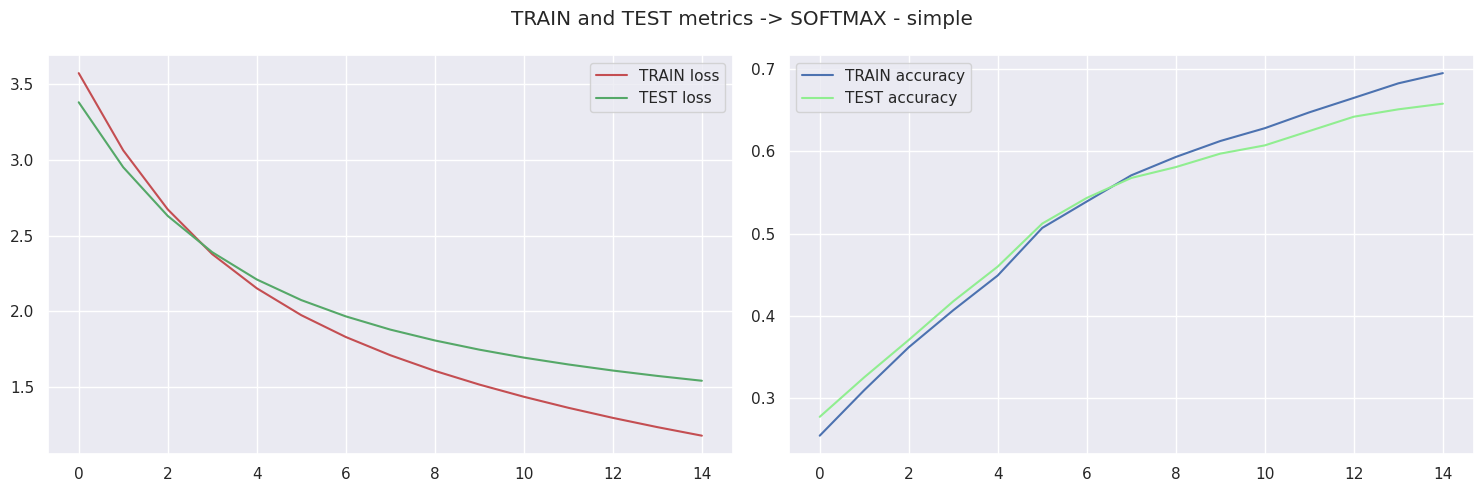

[[1288   64   63  191]
 [ 108   15    8   23]
 [  49    1    9   27]
 [ 212   13   20  278]]


REPORT: 
              precision    recall  f1-score   support

           0       0.78      0.80      0.79      1606
           1       0.16      0.10      0.12       154
           2       0.09      0.10      0.10        86
           3       0.54      0.53      0.53       523

    accuracy                           0.67      2369
   macro avg       0.39      0.38      0.39      2369
weighted avg       0.66      0.67      0.66      2369



In [109]:
softmax_simple_y_pred = softmax_simple_bow.predict(X_test_bow.toarray())
_, softmax_simple_accuracy = softmax_simple_bow.evaluate(X_test_bow.toarray(), 
                                      y_test, verbose=False)

print("SIMPLE SOFTMAX")
print(f"On TEST accuracy: {softmax_simple_accuracy}")
plot_learning_metrics(softmax_simple_bow_result, "SOFTMAX - simple")
print(show_confusion_matrix(y_test.argmax(axis=1), np.argmax(softmax_simple_y_pred, axis=1)))

print("\n\nREPORT: ")
print(metrics.classification_report(y_test.argmax(axis=1), np.argmax(softmax_simple_y_pred, axis=1)))

### TF-IDF words n-gram sequences

In [110]:
softmax_simple_tfidf_w = single_layer_softmax_model(X_train_tfidf_w.toarray().shape)
softmax_simple_tfidf_w_result = softmax_simple_tfidf_w.fit(
    X_train_tfidf_w.toarray(), 
    y_train, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_split=0.2,
    verbose=False)

75/75 [==============================] - 0s 570us/step
SIMPLE SOFTMAX TF-IDF
TEST accuracy: 0.7302659153938293
TRAIN Accuracy: 74.241% 



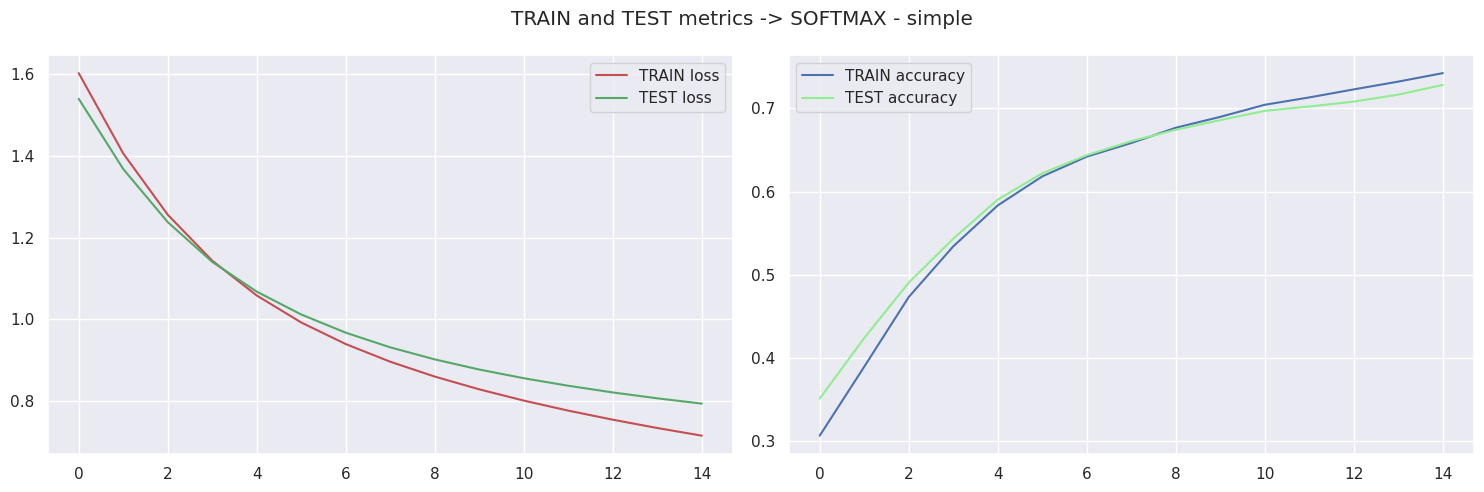

[[1466   15    6  119]
 [ 128    5    0   21]
 [  53    1    4   28]
 [ 258    5    5  255]]


REPORT: 
              precision    recall  f1-score   support

           0       0.77      0.91      0.84      1606
           1       0.19      0.03      0.06       154
           2       0.27      0.05      0.08        86
           3       0.60      0.49      0.54       523

    accuracy                           0.73      2369
   macro avg       0.46      0.37      0.38      2369
weighted avg       0.68      0.73      0.69      2369



In [111]:
softmax_simple_tfidf_w_y_pred = softmax_simple_tfidf_w.predict(X_test_tfidf_w.toarray())
_, softmax_simple_accuracy = softmax_simple_tfidf_w.evaluate(X_test_tfidf_w.toarray(), 
                                      y_test, verbose=False)
print("SIMPLE SOFTMAX TF-IDF")
print(f"TEST accuracy: {softmax_simple_accuracy}")
plot_learning_metrics(softmax_simple_tfidf_w_result, "SOFTMAX - simple")

print(show_confusion_matrix(y_test.argmax(axis=1), np.argmax(softmax_simple_tfidf_w_y_pred, axis=1)))

print("\n\nREPORT: ")
print(metrics.classification_report(y_test.argmax(axis=1), np.argmax(softmax_simple_tfidf_w_y_pred, axis=1)))

### TF-IDF char n-grams

In [112]:
softmax_simple_tfidf_c = single_layer_softmax_model(X_train_tfidf_c.toarray().shape)
softmax_simple_tfidf_c_result = softmax_simple_tfidf_c.fit(
    X_train_tfidf_c.toarray(), 
    y_train, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_split=0.2,
    verbose=False)

2023-05-03 22:58:00.019504: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1427816448 exceeds 10% of free system memory.


75/75 [==============================] - 0s 1ms/step
SIMPLE SOFTMAX - char n-grams
On TEST accuracy: 0.7788096070289612
TRAIN Accuracy: 84.165% 



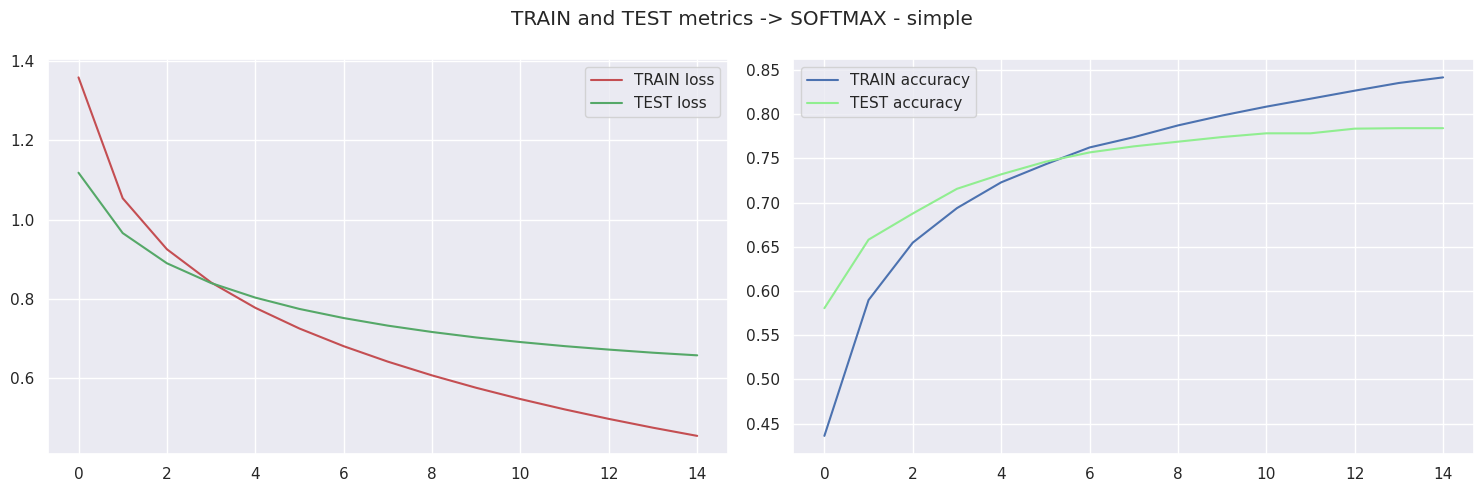



CONFUSION MATRIX
[[1493   19   11   83]
 [ 125   11    3   15]
 [  43    2    9   32]
 [ 179    3    9  332]]


REPORT: 
              precision    recall  f1-score   support

           0       0.81      0.93      0.87      1606
           1       0.31      0.07      0.12       154
           2       0.28      0.10      0.15        86
           3       0.72      0.63      0.67       523

    accuracy                           0.78      2369
   macro avg       0.53      0.44      0.45      2369
weighted avg       0.74      0.78      0.75      2369



In [113]:
softmax_simple_tfidf_c_y_pred = softmax_simple_tfidf_c.predict(X_test_tfidf_c.toarray())
_, softmax_simple_accuracy = softmax_simple_tfidf_c.evaluate(X_test_tfidf_c.toarray(), 
                                      y_test, verbose=False)
print("SIMPLE SOFTMAX - char n-grams")
print(f"On TEST accuracy: {softmax_simple_accuracy}")
plot_learning_metrics(softmax_simple_tfidf_c_result, "SOFTMAX - simple")

print("\n\nCONFUSION MATRIX")
print(show_confusion_matrix(y_test.argmax(axis=1), np.argmax(softmax_simple_tfidf_c_y_pred, axis=1)))

print("\n\nREPORT: ")
print(metrics.classification_report(y_test.argmax(axis=1), np.argmax(softmax_simple_tfidf_c_y_pred, axis=1)))

### Word2Vec

In [114]:
softmax_simple_w2v = single_layer_softmax_model(np.array(X_train_w2v_avg).shape)
softmax_simple_w2v_result = softmax_simple_w2v.fit(
    np.array(X_train_w2v_avg), 
    y_train, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_split=0.2,
    verbose=False)

75/75 [==============================] - 0s 468us/step
SIMPLE SOFTMAX - Word2vec
On TEST accuracy: 0.7273110747337341
TRAIN Accuracy: 73.067% 



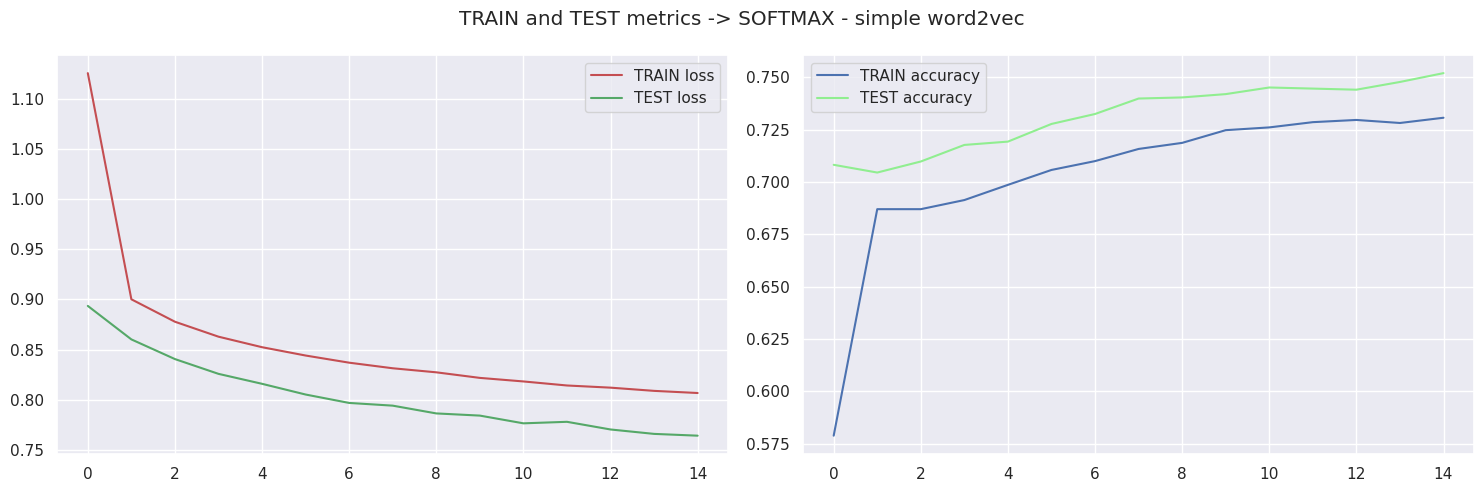



CONFUSION MATRIX
[[1521    0    0   85]
 [ 153    0    0    1]
 [  80    0    0    6]
 [ 321    0    0  202]]


REPORT: 
              precision    recall  f1-score   support

           0       0.73      0.95      0.83      1606
           1       0.00      0.00      0.00       154
           2       0.00      0.00      0.00        86
           3       0.69      0.39      0.49       523

    accuracy                           0.73      2369
   macro avg       0.36      0.33      0.33      2369
weighted avg       0.65      0.73      0.67      2369



/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [115]:
softmax_simple_w2v_y_pred = softmax_simple_w2v.predict(np.array(X_test_w2v_avg))
_, softmax_simple_accuracy = softmax_simple_w2v.evaluate(np.array(X_test_w2v_avg), 
                                      y_test, verbose=False)
print("SIMPLE SOFTMAX - Word2vec")
print(f"On TEST accuracy: {softmax_simple_accuracy}")
plot_learning_metrics(softmax_simple_w2v_result, "SOFTMAX - simple word2vec")

print("\n\nCONFUSION MATRIX")
print(show_confusion_matrix(y_test.argmax(axis=1), np.argmax(softmax_simple_w2v_y_pred, axis=1)))

print("\n\nREPORT: ")
print(metrics.classification_report(y_test.argmax(axis=1), np.argmax(softmax_simple_w2v_y_pred, axis=1)))

## Multi-layer deep neural network

In [116]:
def deep_multilayer_model(input_shape, learning_rate=0.001):
    model = tf.keras.models.Sequential([
        tf.keras.Input(shape=(input_shape[1],)),
#         tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(512,
                              kernel_initializer=tf.keras.initializers.RandomNormal(mean=0, stddev=1.0),
                              kernel_regularizer="l2",
                              activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(256,
                              kernel_regularizer="l2",
                              activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(OUT, activation="softmax")
    ])
    
    model.compile(# Adam + crossentropy
        optimizer=tf.keras.optimizers.Adam(),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    
    return model

### BOW

In [117]:
multi_layer_bow = deep_multilayer_model(X_train_bow.toarray().shape)
multi_layer_bow_result = multi_layer_bow.fit(
    X_train_bow.toarray(),
    y_train, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_split=0.2, 
    verbose=False)

75/75 [==============================] - 0s 4ms/step
[INPUT] -> [512] -[relu]-> [256] -[relu]-> [OUT] -[softmax]
On TEST accuracy: 0.7593921422958374
TRAIN Accuracy: 92.597% 



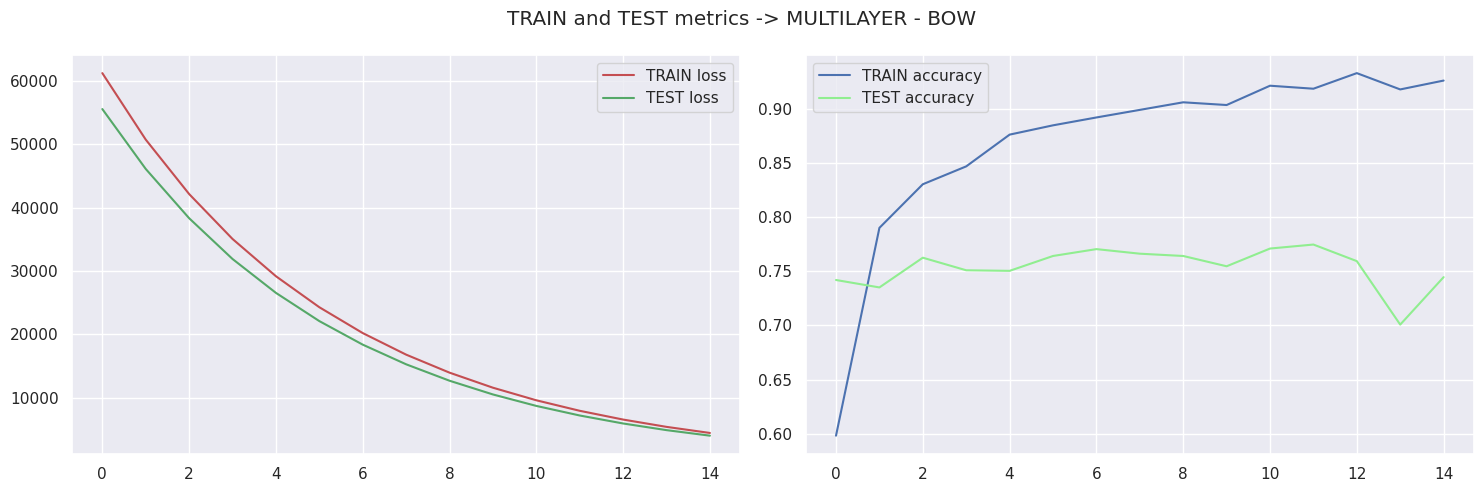



CONFUSION MATRIX
[[1456   27   19  104]
 [ 127   12    1   14]
 [  55    1    8   22]
 [ 173   11   16  323]]


REPORT: 
              precision    recall  f1-score   support

           0       0.80      0.91      0.85      1606
           1       0.24      0.08      0.12       154
           2       0.18      0.09      0.12        86
           3       0.70      0.62      0.66       523

    accuracy                           0.76      2369
   macro avg       0.48      0.42      0.44      2369
weighted avg       0.72      0.76      0.73      2369



In [118]:
multi_layer_bow_y_pred = multi_layer_bow.predict(X_test_bow.toarray())
_, multi_layer_bow_accuracy = multi_layer_bow.evaluate(X_test_bow.toarray(), 
                                      y_test, verbose=False)

print("[INPUT] -> [512] -[relu]-> [256] -[relu]-> [OUT] -[softmax]")
print(f"On TEST accuracy: {multi_layer_bow_accuracy}")
plot_learning_metrics(multi_layer_bow_result, "MULTILAYER - BOW")

print("\n\nCONFUSION MATRIX")
print(show_confusion_matrix(y_test.argmax(axis=1), np.argmax(multi_layer_bow_y_pred, axis=1)))

print("\n\nREPORT: ")
print(metrics.classification_report(y_test.argmax(axis=1), np.argmax(multi_layer_bow_y_pred, axis=1)))

### Word2Vec

In [119]:
multi_layer_w2v = deep_multilayer_model(np.array(X_train_w2v_avg).shape)
multi_layer_w2v_result = multi_layer_w2v.fit(
    np.array(X_train_w2v_avg), 
    y_train, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_split=0.2,
    verbose=False)

75/75 [==============================] - 0s 1ms/step
[INPUT] -> [512] -[relu]-> [256] -[relu]-> [OUT] -[softmax]
On TEST accuracy: 0.7011397480964661
TRAIN Accuracy: 73.885% 



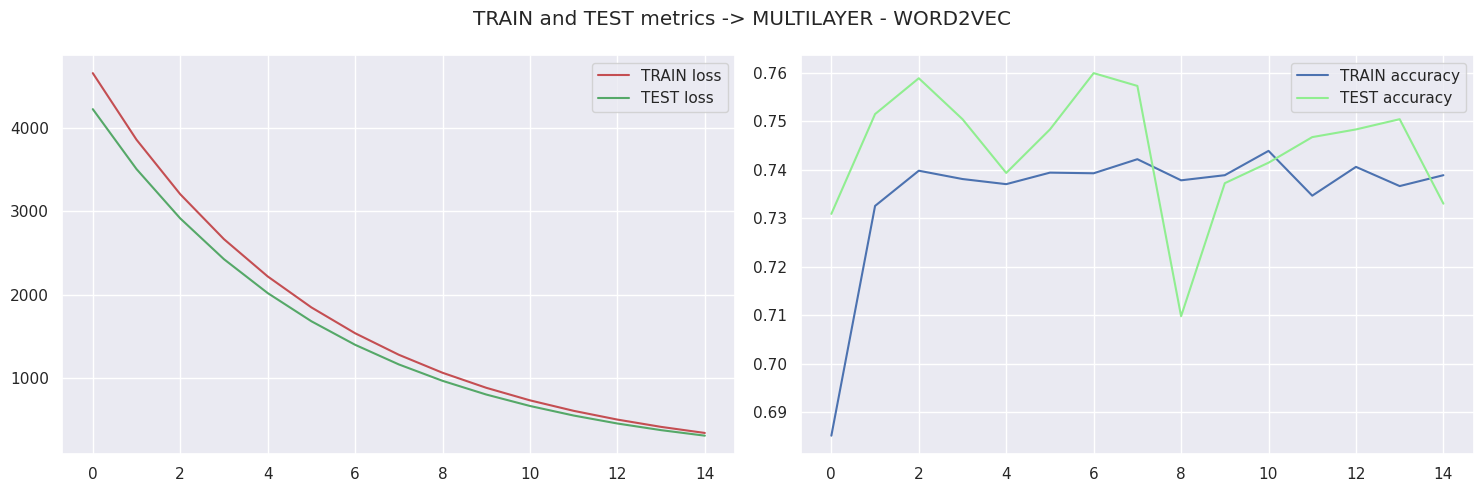



CONFUSION MATRIX
[[1601    0    0    5]
 [ 154    0    0    0]
 [  86    0    0    0]
 [ 463    0    0   60]]


REPORT: 
              precision    recall  f1-score   support

           0       0.69      1.00      0.82      1606
           1       0.00      0.00      0.00       154
           2       0.00      0.00      0.00        86
           3       0.92      0.11      0.20       523

    accuracy                           0.70      2369
   macro avg       0.40      0.28      0.26      2369
weighted avg       0.67      0.70      0.60      2369



/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [120]:
multi_layer_w2v_y_pred = multi_layer_w2v.predict(np.array(X_test_w2v_avg))
_, multi_layer_w2v_accuracy = multi_layer_w2v.evaluate(np.array(X_test_w2v_avg), 
                                      y_test, verbose=False)

print("[INPUT] -> [512] -[relu]-> [256] -[relu]-> [OUT] -[softmax]")
print(f"On TEST accuracy: {multi_layer_w2v_accuracy}")
plot_learning_metrics(multi_layer_w2v_result, "MULTILAYER - WORD2VEC")

print("\n\nCONFUSION MATRIX")
print(show_confusion_matrix(y_test.argmax(axis=1), np.argmax(multi_layer_w2v_y_pred, axis=1)))

print("\n\nREPORT: ")
print(metrics.classification_report(y_test.argmax(axis=1), np.argmax(multi_layer_w2v_y_pred, axis=1)))

#### With generalized dataset

## Multi-layer model with dropout regularization

In [121]:
def deep_multilayer_with_dropout_model(input_shape, learning_rate=0.001):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(input_shape[1],)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(512, activation="relu", kernel_regularizer="l2"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(256, activation="relu", kernel_regularizer="l2"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(128, activation="relu", kernel_regularizer="l2"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(OUT, activation="softmax")
    ])
    
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=["accuracy"])
    
    return model

### BOW

In [122]:
multi_layer_dropout_bow = deep_multilayer_with_dropout_model(X_train_bow_tf.toarray().shape)
multi_layer_dropout_bow_result = multi_layer_dropout_bow.fit(
    X_train_bow_tf.toarray(),
    df_train_tf["max_reactions_category"].to_numpy(), 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_split=0.2, 
    verbose=False)

NameError: name 'X_train_bow_tf' is not defined

In [ ]:
_, multi_layer_dropout_bow_accuracy = multi_layer_dropout_bow.evaluate(X_test_bow_tf.toarray(), 
                                      df_test_tf["max_reactions_category"].to_numpy(), verbose=False)
print("MULTILAYER WITH DROPOUT - BOW")
print(f"On TEST accuracy: {multi_layer_dropout_bow_accuracy}")
plot_learning_metrics(multi_layer_dropout_bow_result, "MULTILAYER WITH DROPOUT - BOW")

### TF-IDF

In [ ]:
multi_layer_dropout_tfidf_wg = deep_multilayer_with_dropout_model(X_train_tfidf_wg.toarray().shape, learning_rate=0.0001)
multi_layer_dropout_tfidf_wg_result = multi_layer_dropout_tfidf_wg.fit(
    X_train_tfidf_wg.toarray(), 
    df_train_tf["max_reactions_category"].to_numpy(), 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_split=0.2,
    verbose=True)

In [ ]:
_, multi_layer_dropout_tfidf_wg_accuracy = multi_layer_dropout_tfidf_wg.evaluate(X_test_tfidf_wg.toarray(), 
                                      df_test_tf["max_reactions_category"].to_numpy(), verbose=False)
print("TF-IDF with DROPOUT")
print(f"On TEST accuracy: {multi_layer_dropout_tfidf_wg_accuracy}")
plot_learning_metrics(multi_layer_dropout_tfidf_wg_result, "TF-IDF with DROPOUT")

#### Усі групи слів

In [ ]:
multi_layer_dropout_tfidf_w = deep_multilayer_with_dropout_model(X_train_tfidf_w.toarray().shape)
multi_layer_dropout_tfidf_w_result = multi_layer_dropout_tfidf_w.fit(
    X_train_tfidf_w.toarray(), 
    df_train_tf["max_reactions_category"].to_numpy(), 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_split=0.2,
    verbose=False)

In [ ]:
_, multi_layer_dropout_tfidf_w_accuracy = multi_layer_dropout_tfidf_w.evaluate(X_test_tfidf_w.toarray(), 
                                      df_test_tf["max_reactions_category"].to_numpy(), verbose=False)
print("TF-IDF with DROPOUT")
print(f"On TEST accuracy: {multi_layer_dropout_tfidf_w_accuracy}")
plot_learning_metrics(multi_layer_dropout_tfidf_w_result, "TF-IDF with DROPOUT")

### Word2Vec

In [ ]:
multi_layer_dropout_w2v = deep_multilayer_with_dropout_model(np.array(X_train_w2v_avg).shape)
multi_layer_dropout_w2v_result = multi_layer_dropout_w2v.fit(
    np.array(X_train_w2v_avg), 
    df_train_tf["max_reactions_category"].to_numpy(), 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_split=0.2,
    verbose=False)

In [ ]:
_, multi_layer_dropout_w2v_accuracy = multi_layer_dropout_w2v.evaluate(np.array(X_test_w2v_avg), 
                                      df_test_tf["max_reactions_category"].to_numpy(), verbose=False)
print("MULTILAYER WITH DROPOUT - Word2Vec")
print(f"On TEST accuracy: {multi_layer_dropout_w2v_accuracy}")
plot_learning_metrics(multi_layer_dropout_w2v_result, "MULTILAYER WITH DROPOUT - Word2Vec")

## Multi-layer with dropout and early stopping

In [ ]:
def multi_layer_with_dropout_early_stopping(input_shape, learning_rate=0.001):
    model = deep_multilayer_with_dropout_model(input_shape, learning_rate)
    callback = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=0.2)
    
    return model, callback

In [ ]:
multi_layer_dropout_tfidf_w, callback = multi_layer_with_dropout_early_stopping(X_train_tfidf_w.toarray().shape)
multi_layer_dropout_tfidf_w_result = multi_layer_dropout_tfidf_w.fit(
    X_train_tfidf_w.toarray(), 
    df_train_tf["max_reactions_category"].to_numpy(), 
    epochs=EPOCHS,
    batch_size=BATCH_SIZE, 
    validation_split=0.2,
    verbose=False)

In [ ]:
_, multi_layer_dropout_tfidf_w_accuracy = multi_layer_dropout_tfidf_w.evaluate(X_test_tfidf_w.toarray(), 
                                      df_test_tf["max_reactions_category"].to_numpy(), verbose=False)
print("TF-IDF with DROPOUT")
print(f"On TEST accuracy: {multi_layer_dropout_tfidf_w_accuracy}")
plot_learning_metrics(multi_layer_dropout_tfidf_w_result, "TF-IDF with DROPOUT")

## Deep CNN

In [ ]:
def deep_cnn_model(input_shape, learning_rate=0.001):
    model = tf.keras.Sequential([
#         tf.keras.layers.Input(shape=(input_shape[1],)),
        tf.keras.layers.Conv1D(512, 3, activation="relu", padding="same", input_shape=(input_shape[1],1)),
        tf.keras.layers.AveragePooling1D(pool_size=3),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv1D(256, 3, activation="relu", padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.AveragePooling1D(pool_size=3),
        tf.keras.layers.Conv1D(128, 3, activation="relu", padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv1D(64, 3, activation="relu", padding="same"),
        tf.keras.layers.AveragePooling1D(pool_size=3, padding="same"),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Flatten(),
        
#         tf.keras.layers.BatchNormalization(),
#         tf.keras.layers.Dense(512, activation="relu", kernel_regularizer="l2"),
#         tf.keras.layers.Dropout(0.5),
#         tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.BatchNormalization(),
#         tf.keras.layers.Dropout(0.5),
#         tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.BatchNormalization(),
#         tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(OUT, activation="softmax")
    ])
    
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=["accuracy"])
    
    return model

## BOW

In [ ]:
deep_cnn_bow = deep_multilayer_with_dropout_model(X_train_bow_tf.toarray().shape)
deep_cnn_bow_result = deep_cnn_bow.fit(
    X_train_bow_tf.toarray(),
    df_train_tf["max_reactions_category"].to_numpy(), 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_split=0.2, 
    verbose=True)

In [ ]:
_, deep_cnn_bow_accuracy = deep_cnn_bow.evaluate(X_test_bow_tf.toarray(), 
                                      df_test_tf["max_reactions_category"].to_numpy(), verbose=False)
print("CNN - BOW")
print(f"On TEST accuracy: {deep_cnn_bow_accuracy}")
plot_learning_metrics(deep_cnn_bow_result, "CNN - BOW")

### TF-IDF

#### Тільки словосполучення

In [ ]:
deep_cnn_tfidf_wg = deep_multilayer_with_dropout_model(X_train_tfidf_wg.toarray().shape)
deep_cnn_tfidf_wg_result = deep_cnn_tfidf_wg.fit(
    X_train_tfidf_wg.toarray(), 
    df_train_tf["max_reactions_category"].to_numpy(), 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_split=0.2,
    verbose=True)

In [ ]:
_, deep_cnn_tfidf_wg_accuracy = deep_cnn_tfidf_wg.evaluate(X_test_tfidf_wg.toarray(), 
                                      df_test_tf["max_reactions_category"].to_numpy(), verbose=False)
print("CNN - TF-IDF WG")
print(f"On TEST accuracy: {deep_cnn_tfidf_wg_accuracy}")
plot_learning_metrics(deep_cnn_tfidf_wg_result, "CNN WG")

#### Усі групи слів

In [ ]:
deep_cnn_tfidf_w = deep_multilayer_with_dropout_model(X_train_tfidf_w.toarray().shape)
deep_cnn_tfidf_w_result = deep_cnn_tfidf_w.fit(
    X_train_tfidf_w.toarray(), 
    df_train_tf["max_reactions_category"].to_numpy(), 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_split=0.2,
    verbose=True)

In [ ]:
_, deep_cnn_tfidf_w_accuracy = deep_cnn_tfidf_w.evaluate(X_test_tfidf_w.toarray(), 
                                      df_test_tf["max_reactions_category"].to_numpy(), verbose=False)
print("CNN - TF-IDF")
print(f"On TEST accuracy: {deep_cnn_tfidf_w_accuracy}")
plot_learning_metrics(deep_cnn_tfidf_w_result, "CNN")

### Word2vec

In [ ]:
deep_cnn_w2v = deep_cnn_model(np.array(X_train_w2v_avg).shape, learning_rate=0.00001)
deep_cnn_w2v_result = deep_cnn_w2v.fit(
    np.array(X_train_w2v_avg), 
    df_train_tf["max_reactions_category"].to_numpy(), 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_split=0.2,
    verbose=True)

In [ ]:
_, deep_cnn_w2v_accuracy = deep_cnn_w2v.evaluate(np.array(X_test_w2v_avg), 
                                      df_test_tf["max_reactions_category"].to_numpy(), verbose=False)
print("MULTILAYER CNN - Word2Vec")
print(f"On TEST accuracy: {deep_cnn_w2v_accuracy}")
plot_learning_metrics(deep_cnn_w2v_result, "MULTILAYER CNN - Word2Vec")

## Зіставлені категорії

#### Word2Vec

In [ ]:
multi_layer_w2v = deep_multilayer_model(np.array(X_train_w2v_avg).shape)
multi_layer_w2v_result = multi_layer_w2v.fit(
    np.array(X_train_w2v_avg), 
    df_train_tf["max_reactions_category_generalized"].to_numpy(), 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_split=0.2,
    verbose=False)

In [ ]:
_, multi_layer_w2v_accuracy = multi_layer_w2v.evaluate(np.array(X_test_w2v_avg), 
                                      df_test_tf["max_reactions_category_generalized"].to_numpy(), verbose=False)
print("SIMPLE SOFTMAX")
print(f"On TEST accuracy: {multi_layer_w2v_accuracy}")
plot_learning_metrics(multi_layer_w2v_result, "SOFTMAX - simple")

#### TF-IDF word groups

In [ ]:
multi_layer_dropout_tfidf_wg = deep_multilayer_with_dropout_model(X_train_tfidf_wg.toarray().shape, learning_rate=0.0001)
multi_layer_dropout_tfidf_wg_result = multi_layer_dropout_tfidf_wg.fit(
    X_train_tfidf_wg.toarray(), 
    df_train_tf["max_reactions_category_generalized"].to_numpy(), 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_split=0.2,
    verbose=True)

In [ ]:
_, multi_layer_dropout_tfidf_wg_accuracy = multi_layer_dropout_tfidf_wg.evaluate(X_test_tfidf_wg.toarray(), 
                                      df_test_tf["max_reactions_category_generalized"].to_numpy(), verbose=False)
print("TF-IDF with DROPOUT")
print(f"On TEST accuracy: {multi_layer_dropout_tfidf_wg_accuracy}")
plot_learning_metrics(multi_layer_dropout_tfidf_wg_result, "TF-IDF with DROPOUT")

# Аналіз отриманих результатів
Зняття отриманих метрик та проведення аналізу отриманого результату

In [ ]:
def classification_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    
#     f1 = f1_score(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average="macro")
    f1_micro = f1_score(y_true, y_pred, average="micro")
    f1_weighted = f1_score(y_true, y_pred, average="weighted")
    
#     precision = precision_score(y_true, y_pred)
#     precision_macro = average_precision_score(y_true, y_pred, average="macro")
#     precision_micro = average_precision_score(y_true, y_pred, average="micro")
#     precision_weighted = average_precision_score(y_true, y_pred, average="weighted")
    
    recall = recall_score(y_true, y_pred, average="macro")
    
#     fpr, fnr, thresholds = det_curve(y_true, y_pred, pos_label=int)
    
    return {
        "accuracy": accuracy,
#         "f1": f1,
        "f1_macro": f1_macro,
        "f1_micro": f1_micro,
        "f1_weighted": f1_weighted,
#         "precision": precision,
#         "precision_macro": precision_macro,
#         "precision_micro": precision_micro,
#         "precision_weighted": precision_weighted,
#         "recall": recall,
#         "fpr": fpr, # False Acceptance Rate
#         "fnr": fnr # False Rejection Rate
    }

In [ ]:
classification_metrics(df_test["max_reactions_category"], y_pred_val_labels_bow)

In [ ]:
classification_metrics(df_test["max_reactions_category"], y_pred_val_labels_tfidf_w)

In [ ]:
classification_metrics(df_test["max_reactions_category"], y_pred_val_labels_tfidf_c)